# Variational Autoencoder for the not-MNIST dataset

We will use a probabilisitc non-linear generative model for the not-MNIST dataset. Unlike the localization example, we will train both the **generative model parameters** and the parameters of the **amortized variaitonal family**.

----

<img src="genmodel.png" style="width: 800px;">


---

----

<img src="infermodel.png" style="width: 800px;">


---


## ELBO lower-bound to $p(\mathbf{X})$

<img src="ELBO.png" style="width: 800px;">

Where $\text{KL}(q_{\eta,\mathbf{x}}(\mathbf{z})||p(\mathbf{z}))$ is known in closed form since it is the KL divergence between two Gaussian pdfs:

\begin{align}
\text{KL}(q_{\eta,\mathbf{x}}(\mathbf{z})||p(\mathbf{z})) = \frac{1}{2} \left[\text{tr}\left(\text{diag}(\sigma_{\eta}(\mathbf{x}))\right)+\left(\mu_{\eta}(\mathbf{x})^T\mu_{\eta}(\mathbf{x})\right)-2-\log\det \left(\text{diag}(\sigma_{\eta}(\mathbf{x}))\right) \right]
\end{align}

## SGD optimization

- Sample a M-size minibatch of images.
- Sample $\mathbf{\epsilon}^{(i)}$ from $\mathcal{N}(\mathbf{0},\mathbf{I})$, $i=1,\ldots,M$.
- For $i=1,\ldots,M$, compute
\begin{align}
\mathbf{z}^{(i)} = \mu_\eta(\mathbf{x}^{(i)}) + \sqrt{\text{diag}(\sigma_\eta(\mathbf{x}^{(i)}))} \circ \mathbf{\epsilon}^{(i)}
\end{align}
- Compute gradients of 
\begin{align}
\hat{\mathcal{L}}(\mathbf{X},\theta,\eta) =\sum_{i=1}^M \Big(\log  p_\theta(\mathbf{x}^{(i)}|\mathbf{z}^{(i)}) - \text{KL}(q_{\eta,\mathbf{x}^{(i)}}(\mathbf{z})||p(\mathbf{z}))\Big)
\end{align}
w.r.t. $\theta,\eta$
- Perform SGD update




In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from IPython.display import display, Image
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# use seaborn plotting defaults
import seaborn as sns; sns.set()

### Loading a dataset of images of 10 letters (not MNIST)

In [5]:
pickle_file = '../../../DataSets/notMNIST/notMNIST_4e3_2e3_10e3.pickle' ## Change according to the folder where you saved the dataset provided

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (4000, 28, 28) (4000,)
Validation set (2000, 28, 28) (2000,)
Test set (10000, 28, 28) (10000,)


Lets visualize some of the images ...

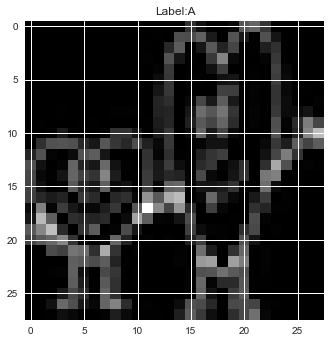

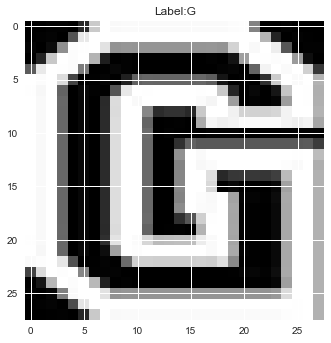

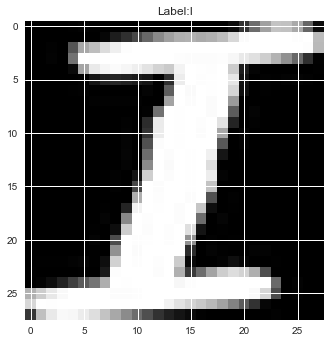

In [6]:
#Generate a random index
num_figs=3

index=np.random.randint(train_dataset.shape[0], size=num_figs)

str_labels = ['A','B','C','D','E','F','G','H','I','J']

for i in range(num_figs):
    plt.figure()
    plt.imshow(train_dataset[index[i],:,:],cmap=plt.cm.gray)
    plt.title('Label:' + str_labels[train_labels[index[i]]])

### TensorFlow Computation Graph and Loss Function

In [24]:
z_dim = 2       #Latent Space

model_name = 'model1'   #In 'model1.py' we define the variational family

learning_rate = 1e-2
num_imgs = 50        #Number of samples generated from the generative model (for testing)
num_iter = 2000      #SGD iterations
period_plot = 100   
sigma_reconstruction = 0.01 #Reconstruction variance
batch_size = 100
dims = [batch_size,784]

In [18]:
sess_VAE = tf.Graph()

with sess_VAE.as_default():
    
    print('[*] Importing model: ' + model_name)
    model = __import__(model_name)
    
    print('[*] Defining placeholders')

    inputX = tf.placeholder(tf.float32, shape=dims, name='x-input')
    
    print('[*] Defining the encoder')
    log_var, mean, sample_z, KL = model.encoder(inputX,z_dim,batch_size)
        
    print('[*] Defining the decoder')
    
    loglik,img_reconstruction = model.decoder(inputX,sample_z,sigma_reconstruction,dims[1])  
        
    loss = -tf.reduce_mean(loglik - KL)
    
    optim = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    print('[*] Defining Sample operation...')
    samples = model.new_samples(num_imgs, z_dim, dims[1])  
    
    # Output dictionary -> Useful if computation graph is defined in a separate .py file
    
    tf_nodes = {}
    
    tf_nodes['X'] = inputX
    
    tf_nodes['mean'] = mean
    
    tf_nodes['logvar'] = log_var

    tf_nodes['KL'] = tf.reduce_mean(KL)
    
    tf_nodes['loglik'] = tf.reduce_mean(loglik)
    
    tf_nodes['img_reconst'] = img_reconstruction
    
    tf_nodes['optim'] = optim
    
    tf_nodes['samples'] = samples
    

[*] Importing model: model1
[*] Defining placeholders
[*] Defining the encoder
[*] Defining the decoder
[*] Defining Sample operation...


## SGD optimization

In [25]:
   
############ SGD Inference #####################################

with tf.Session(graph=sess_VAE) as session:
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    tf.global_variables_initializer().run()
        
    print('Training the VAE ...')    
    
    for it in range(num_iter):
        
        
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        
        offset = (it * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        
        batch_data = train_dataset[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.

        feedDict = {tf_nodes['X'] : batch_data.reshape([-1,784])}  

        _,loglik,KL= session.run([tf_nodes['optim'],tf_nodes['loglik'],tf_nodes['KL']],feedDict)

        if(it % period_plot ==0):

            print("It = %d, loglik = %.5f, KL = %.5f" %(it,loglik,KL))


    it = 0
    offset = (it * batch_size) % (train_labels.shape[0] - batch_size)

    batch_data_train = train_dataset[offset:(offset + batch_size), :]
    batch_data_test = test_dataset[offset:(offset + batch_size), :]

    #We compute the latent representation of batch images and their reconstruction
    feedDict = {tf_nodes['X'] : batch_data_train.reshape([-1,784])} 
    z,reconstructions_train = session.run([tf_nodes['mean'],tf_nodes['img_reconst']], feed_dict=feedDict)

    feedDict = {tf_nodes['X'] : batch_data_test.reshape([-1,784])} 
    reconstructions_test = session.run(tf_nodes['img_reconst'], feed_dict=feedDict)

    samples = session.run(tf_nodes['samples'])


Training the VAE ...
It = 0, loglik = -8751.63281, KL = 0.40239
It = 100, loglik = -5439.83105, KL = 16.31158
It = 200, loglik = -5190.51172, KL = 17.71518
It = 300, loglik = -5328.92334, KL = 24.28795
It = 400, loglik = -5261.45605, KL = 21.94385
It = 500, loglik = -4533.56543, KL = 26.77709
It = 600, loglik = -4792.50000, KL = 29.26538
It = 700, loglik = -4709.96680, KL = 32.60442
It = 800, loglik = -4620.43604, KL = 27.55295
It = 900, loglik = -4370.47852, KL = 34.41415
It = 1000, loglik = -4470.29688, KL = 33.15555
It = 1100, loglik = -4779.98926, KL = 36.63934
It = 1200, loglik = -4494.06348, KL = 38.13942
It = 1300, loglik = -4651.29395, KL = 32.05114
It = 1400, loglik = -4481.19189, KL = 36.36169
It = 1500, loglik = -4281.56396, KL = 38.35944
It = 1600, loglik = -4194.37891, KL = 39.18999
It = 1700, loglik = -4339.29834, KL = 39.60637
It = 1800, loglik = -4341.74707, KL = 41.29792
It = 1900, loglik = -4259.43896, KL = 41.00307


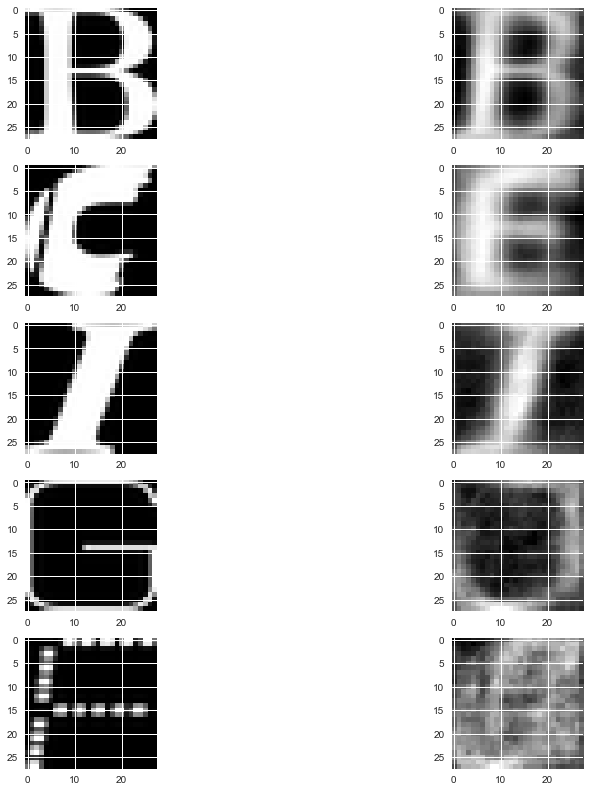

In [26]:
#Lets plot train images and their reconstruction

n_plots_axis=5

f2, axarr2 = plt.subplots(n_plots_axis,2)

for i in range(n_plots_axis):

    axarr2[i,0].imshow(batch_data_train[i,:].reshape([28,28]),cmap='gray');
    axarr2[i,1].imshow(reconstructions_train[i,:].reshape([28,28]),cmap='gray') 
    

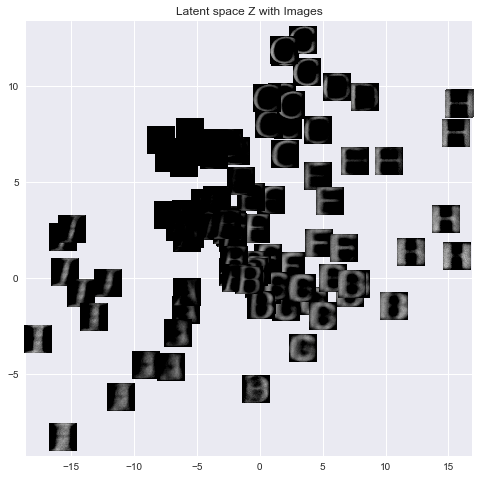

In [27]:
# Lets plot latent representation of train images

def plot_latent_space_with_images(ax,recons_images,z_samples):
    

    ax.clear()
    for i in range(len(recons_images)):
        im = OffsetImage(recons_images[i].reshape([28,28]), zoom=1,cmap='gray',norm=mpl.colors.Normalize(0,1))
        ab = AnnotationBbox(im, z_samples[i],frameon=False)
        ax.add_artist(ab)
    ax.set_xlim(np.min(z_samples[:,0])-1,np.max(z_samples[:,0])+1)
    ax.set_ylim(np.min(z_samples[:,1])-1,np.max(z_samples[:,1])+1)
    ax.set_title('Latent space Z with Images')
    
plt.figure()
f_latent, ax_latent = plt.subplots(1,1,figsize=(8, 8))
plot_latent_space_with_images(ax_latent,reconstructions_train,z) 
plt.rcParams["figure.figsize"] = [14,14]

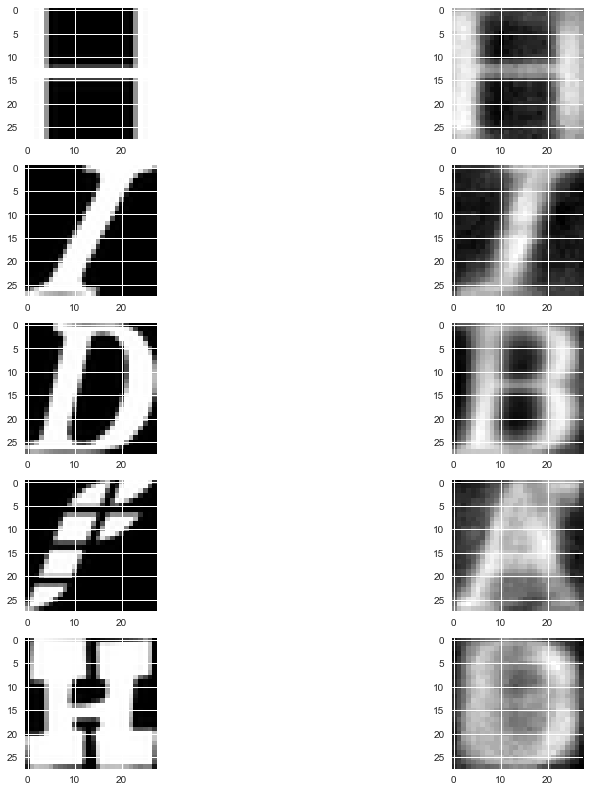

In [28]:
# Lets plot latent representation of test images

f3, axarr3 = plt.subplots(n_plots_axis,2)

for i in range(n_plots_axis):

    axarr3[i,0].imshow(batch_data_test[i,:].reshape([28,28]),cmap='gray');
    axarr3[i,1].imshow(reconstructions_test[i,:].reshape([28,28]),cmap='gray')


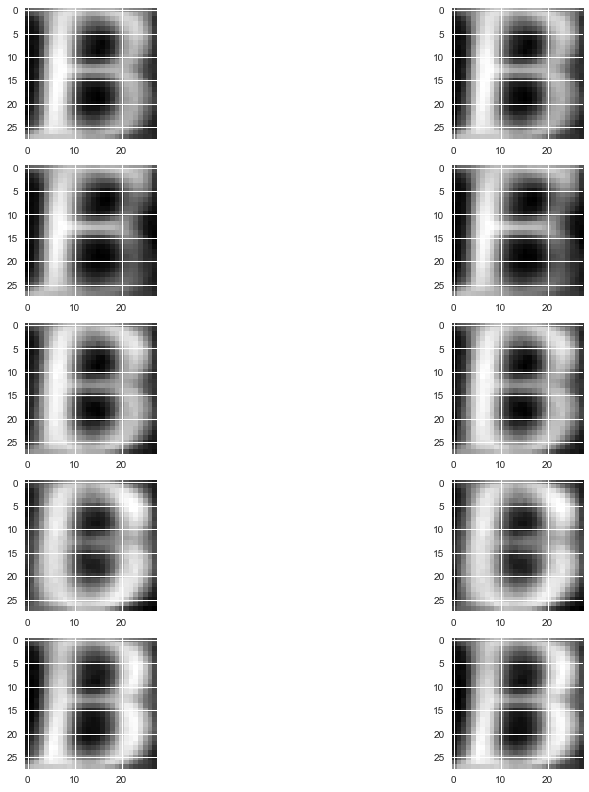

In [29]:
# Lets plot samples of the model


n_plots_axis=5

f4, axarr4 = plt.subplots(n_plots_axis,2)

for i in range(n_plots_axis):

    axarr4[i,0].imshow(samples[i,:].reshape([28,28]),cmap='gray');
    axarr4[i,1].imshow(samples[i,:].reshape([28,28]),cmap='gray') 
    